[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juanchess98/Notebooks-Deep-Learning/blob/transfer_learning/TL_CASO_4.ipynb)

## Caso 4. La nueva base de datos es pequeña y similar a la original

Si la nueva base de datos es pequeña y se parece a la base de datos del modelo preentrenado, los pasos son los siguientes:

1. Quitar la última capa totalmente conectada de la red neuronal.
2. Congelar todos los pesos de la red pre-entrenada.
3. Añadir una nueva capa totalmente conectada que tenga como dimensiones de salida el número de clases del nuevo dataset.
4. Aleatorizar los pesos de la nueva capa totalmente conectada.
5. Entrenar la red para actualizar los pesos de la nueva capa totalmente conectada.

In [1]:
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

### Cargar la base de datos similar

En este ejemplo se usará CIFAR10 como nueva base de datos similar a la base de datos del modelo pre-entrenado (Imagenet). CIFAR10 está conformada por imágenes de dimensión 3x32x32, es decir, 3 canales y resolución 32x32 píxeles. Asimismo, cuenta con 10 clases que son:  ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

En el siguiente bloque se muestra el procedimiento para cargar la base de datos CIFAR10 usando el paquete Torchvision de PyTorch que incluye dataloaders para algunas de las bases de datos más comunes en visión por computadora.

data_dir = 'data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [12]:
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

image_datasets = {x: datasets.CIFAR10(root='./data', train=x=='train', 
                     download=True, transform=transform) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                              shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


En la siguiente función está nuestro modelo de entrenamiento

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs).to(device)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Visualización de imágenes del nuevo dataset

La siguiente función la usamos para ver algunas de las imágenes de la nueva base de datos CIFAR10 y se imprime su respectiva etiqueta.

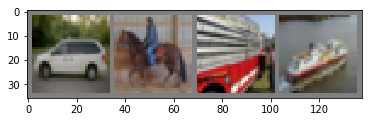

  car horse truck  ship


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Paso 1. Cargar el modelo preentrenado

Se carga el modelo de la red VGG16 pre-entrenado con ImageNet al hacer 𝑝𝑟𝑒𝑡𝑟𝑎𝑖𝑛𝑒𝑑=𝑇𝑟𝑢𝑒. Nótese que las dimensiones de la última capa de salida son (4096, 1000), donde 1000 es el número de clases de la base de datos Imagenet.

In [5]:
pretrained_model = models.vgg16(pretrained=True)
pretrained_model.to(device)
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Paso 2. Congelar los pesos

Se congelan todos los pesos de la red pre-entrenada con $requires_grad = False$, esto impide que se calculen los gradientes en back-propagation.

In [6]:
for param in pretrained_model.parameters():
    param.requires_grad = False

### Paso 3. Agregar una nueva capa totalmente conectada

Se quita la última capa totalmente conectada del modelo pre-entrenado y se reemplaza por una capa nueva con dimensiones de salida (4096, 10), donde 10 es el número de clases de CIFAR10.

Al agregar una nueva capa por defecto se tiene que $requires_autograd = True$,
dejamos este valor ya que queremos entrenar los pesos de esta capa. 

In [7]:
criterion = nn.CrossEntropyLoss().to(device)
pretrained_model.classifier[6]= nn.Linear(4096, 10)
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

### Paso 5.  Entrenar el modelo

In [8]:
optimizer_conv = optim.SGD(pretrained_model.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [9]:
pretrained_model = train_model(pretrained_model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/2
----------
train Loss: 7.6984 Acc: 0.4512
val Loss: 5.0447 Acc: 0.5383

Epoch 1/2
----------
train Loss: 8.6088 Acc: 0.4775
val Loss: 5.2105 Acc: 0.5449

Epoch 2/2
----------
train Loss: 8.7446 Acc: 0.4809
val Loss: 5.3198 Acc: 0.5651

Training complete in 7m 32s
Best val Acc: 0.565100


### Visualizar el modelo y predecir

In [10]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

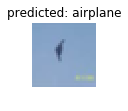

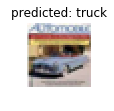

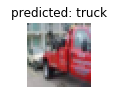

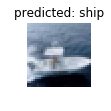

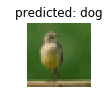

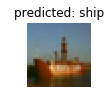

In [13]:
visualize_model(pretrained_model)

plt.ioff()
plt.show()